In [1]:
import pandas as pd
import os
import numpy as np
from tqdm.auto import tqdm

# Load the raw TSV files
df_train = pd.read_csv("./data/multimodal_train.tsv", sep="\t")
df_val = pd.read_csv("./data/multimodal_validate.tsv", sep="\t")

# Combine datasets
df_full = pd.concat([df_train, df_val], ignore_index=True)

print(f"Total samples available: {len(df_full)}")
print(f"Columns: {list(df_full.columns)}")
print("\nFirst few rows:")
print(df_full.head())

# Check label distribution
print("\nLabel distribution:")
print(df_full['2_way_label'].value_counts())

Total samples available: 623342
Columns: ['author', 'clean_title', 'created_utc', 'domain', 'hasImage', 'id', 'image_url', 'linked_submission_id', 'num_comments', 'score', 'subreddit', 'title', 'upvote_ratio', '2_way_label', '3_way_label', '6_way_label']

First few rows:
           author                                        clean_title  \
0     Alexithymia  my walgreens offbrand mucinex was engraved wit...   
1        VIDCAs17                this concerned sink with a tiny hat   
2  prometheus1123      hackers leak emails from uae ambassador to us   
3             NaN                           puppy taking in the view   
4       3rikR3ith               i found a face in my sheet music too   

    created_utc         domain  hasImage      id  \
0  1.551641e+09    i.imgur.com      True  awxhir   
1  1.534727e+09      i.redd.it      True  98pbid   
2  1.496511e+09  aljazeera.com      True  6f2cy5   
3  1.471341e+09    i.imgur.com      True  4xypkv   
4  1.525318e+09      i.redd.it     

In [2]:
n_target = 4000

true = df_full.loc[(df_full["2_way_label"] == 1) & ~(df_full["image_url"].isnull())]
fake = df_full.loc[(df_full["2_way_label"] == 0) & ~(df_full["image_url"].isnull())]

# Select the image url only for a valid URL http://i.imgur.com/Iauyw9R.jpg	
fileTypes = ["jpg", "jpeg"]


# Filter 
true_img_url = true.loc[true["image_url"].str.contains("|".join(fileTypes), na=False, case=False)]
fake_img_url = fake.loc[fake["image_url"].str.contains("|".join(fileTypes), na=False, case=False)]


true_sample = true_img_url.sample(n=n_target)
fake_sample = fake_img_url.sample(n=n_target)

df = pd.concat([true_sample, fake_sample], ignore_index=True)


df.shape

(8000, 16)

In [3]:
import os
import pandas as pd
idss = []
for path, dirs, filename in os.walk("./fakeddit_sample/images/"):
    for file in filename:
        ids = file.split(".")[0]
        idss.append(ids)



valid_image_df = df_full[df_full["id"].isin(idss)]


true_valid = valid_image_df[valid_image_df["2_way_label"] == 1]
fake_valid = valid_image_df[valid_image_df["2_way_label"] == 0]

downsam_true = true_valid.sample(n=len(fake_valid), random_state=42)

balanced_df = pd.concat([downsam_true, fake_valid])

balanced_df["2_way_label"].value_counts()

2_way_label
1    1813
0    1813
Name: count, dtype: int64

In [4]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, CLIPVisionModel, CLIPProcessor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from PIL import Image
from tqdm import tqdm
import pickle
import torch.nn.functional as F

In [5]:
class TextExtractor:
    def __init__(self):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")
        
        # Text embedding extractor (Mistral 7B)
        self.text_tokenizer = AutoTokenizer.from_pretrained("mistralai/Mistral-7B-v0.1")
        if self.text_tokenizer.pad_token is None:
            self.text_tokenizer.pad_token = self.text_tokenizer.eos_token
        
        self.text_model = AutoModel.from_pretrained(
            "mistralai/Mistral-7B-v0.1", 
            torch_dtype=torch.float16,  # Keep FP16 for memory efficiency
            device_map="auto",  # Let transformers handle device mapping
            low_cpu_mem_usage=True  # Additional memory optimization
        )
        
        
        
        # Freeze all parameters - NO TRAINING on these models
        for param in self.text_model.parameters():
            param.requires_grad = False
    
            
        self.text_model.eval()
        
        
    
    def average_pool(self, last_hidden_states, attention_mask):
        """Average pooling for E5 embeddings"""
        last_hidden = last_hidden_states.masked_fill(~attention_mask[..., None].bool(), 0.0)
        return last_hidden.sum(dim=1) / attention_mask.sum(dim=1)[..., None]
    
    def extract_text_embeddings(self, texts, batch_size=32):
        """Extract text embeddings using E5-Large-v2"""
        all_embeddings = []
        
        for i in tqdm(range(0, len(texts), batch_size), desc="Extracting mistral text embeddings"):
            batch_texts = texts[i:i+batch_size]
            
            # Add E5 prefix and handle empty texts
            processed_texts = []
            for text in batch_texts:
                if pd.isna(text) or text is None or str(text).strip() == "":
                    processed_texts.append("query: [NO TEXT]")
                else:
                    processed_texts.append(f"query: {str(text)}")
            
            # Tokenize
            batch_dict = self.text_tokenizer(
                processed_texts,
                max_length=512,
                padding=True,
                truncation=True,
                return_tensors='pt'
            ).to(self.device)
            
            # Extract embeddings
            with torch.no_grad():
                outputs = self.text_model(**batch_dict)
                embeddings = self.average_pool(outputs.last_hidden_state, batch_dict['attention_mask'])
                # Normalize embeddings (E5 best practice)
                embeddings = F.normalize(embeddings, p=2, dim=1)
                all_embeddings.append(embeddings.cpu())
            
            # Memory cleanup
            if i % 20 == 0:
                torch.cuda.empty_cache()
        
        return torch.cat(all_embeddings, dim=0).numpy()
    
   
# Usage
extractor = TextExtractor()



Using device: cuda


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
def extract_all_embeddings_robust(df, extractor):
    
    print(f"Processing ALL {len(df)} samples")
    
    # Process ALL texts (handle empty ones gracefully)
    texts = []
    for text in df['clean_title']:
        if pd.isna(text) or str(text).strip() == "":
            texts.append("No title available")  # Meaningful placeholder
        else:
            texts.append(str(text))
    
    text_embeddings = extractor.extract_text_embeddings(texts, batch_size=32)
    print(f"Text embeddings: {text_embeddings.shape}")
    
    labels = df['2_way_label'].values
    
    return {
        'text_embeddings': text_embeddings,
        'labels': labels,
        
    }

embeddings_data = extract_all_embeddings_robust(balanced_df, extractor)

# Save silently
with open('./embeddings/mistral-textonly.pkl', 'wb') as f:
    pickle.dump(embeddings_data, f)


Processing ALL 3626 samples


Extracting mistral text embeddings: 100%|██████████| 114/114 [00:22<00:00,  5.17it/s]


Text embeddings: (3626, 4096)


In [7]:
class TextEmbeddingDataset(Dataset):
    """Dataset for text embeddings only"""
    def __init__(self, text_embeddings, labels):
        self.text_embeddings = torch.tensor(text_embeddings, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            'text_emb': self.text_embeddings[idx],
            'label': self.labels[idx]
        }

# Assuming you have your embeddings_data from previous work
text_embeddings = embeddings_data['text_embeddings']  # Shape: (3626, 1024)
labels = embeddings_data['labels']  # Shape: (3626,)

print(f"Text embeddings shape: {text_embeddings.shape}")
print(f"Labels shape: {labels.shape}")

Text embeddings shape: (3626, 4096)
Labels shape: (3626,)


In [8]:
class TextOnlyBaselineMLP(nn.Module):
    def __init__(self, embedding_dim=4096):
        super().__init__()
        
        self.classifier = nn.Sequential(
            # First layer
            nn.Linear(embedding_dim, 512),
            nn.LayerNorm(512),
            nn.GELU(),
            nn.Dropout(0.3),
            
            # Second layer
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.GELU(),
            nn.Dropout(0.2),
            
            # Output layer
            nn.Linear(256, 2)  # Binary classification (real/fake)
        )
        
        print(f"Text-only model initialized with {sum(p.numel() for p in self.parameters()):,} parameters")
    
    def forward(self, text_emb):
        return self.classifier(text_emb)

# Create model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
text_model = TextOnlyBaselineMLP(embedding_dim=4096).to(device)

Text-only model initialized with 2,231,042 parameters


In [9]:
from torch.utils.data import random_split

# Create dataset
full_dataset = TextEmbeddingDataset(text_embeddings, labels)

# Split: 60% train, 20% validation, 20% test
total_size = len(full_dataset)
train_size = int(0.6 * total_size)
val_size = int(0.2 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

# Create all three loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)  # New!


Training samples: 2175
Validation samples: 725
Test samples: 726


In [10]:
# Training configuration
optimizer = torch.optim.AdamW(text_model.parameters(), lr=1e-3, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30)

# Training functions
def train_text_epoch(model, train_loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch in tqdm(train_loader, desc="Training"):
        text_emb = batch['text_emb'].to(device)
        labels = batch['label'].to(device)
        
        optimizer.zero_grad()
        logits = model(text_emb)
        loss = criterion(logits, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        _, predicted = torch.max(logits.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    return total_loss / len(train_loader), correct / total

def validate_text_epoch(model, val_loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Validating"):
            text_emb = batch['text_emb'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(text_emb)
            loss = criterion(logits, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(logits.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return total_loss / len(val_loader), correct / total


In [11]:
# Training loop
num_epochs = 30
best_val_acc = 0
patience = 5
patience_counter = 0

print("🚀 Starting Text-Only Baseline Training!")
print("=" * 60)

for epoch in range(num_epochs):
    # Train
    train_loss, train_acc = train_text_epoch(text_model, train_loader, optimizer, criterion, device)
    
    # Validate
    val_loss, val_acc = validate_text_epoch(text_model, val_loader, criterion, device)
    
    # Step scheduler
    scheduler.step()
    
    print(f"Epoch {epoch+1:2d}: Train Loss={train_loss:.4f}, Train Acc={train_acc:.4f}, "
          f"Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(text_model.state_dict(), './models/best_model3.pth')
        print(f"🎉 New best text-only model saved! Val Acc: {val_acc:.4f}")
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered!")
            break

print(f"✅ Text-only training completed! Best validation accuracy: {best_val_acc:.4f}")


🚀 Starting Text-Only Baseline Training!


Validating: 100%|██████████| 12/12 [00:00<00:00, 576.04it/s]


Epoch  1: Train Loss=0.7427, Train Acc=0.5278, Val Loss=0.6730, Val Acc=0.5848
🎉 New best text-only model saved! Val Acc: 0.5848


Validating: 100%|██████████| 12/12 [00:00<00:00, 562.46it/s]


Epoch  2: Train Loss=0.6263, Train Acc=0.6441, Val Loss=0.5552, Val Acc=0.7048
🎉 New best text-only model saved! Val Acc: 0.7048


Validating: 100%|██████████| 12/12 [00:00<00:00, 429.07it/s]


Epoch  3: Train Loss=0.5326, Train Acc=0.7343, Val Loss=0.5128, Val Acc=0.7366
🎉 New best text-only model saved! Val Acc: 0.7366


Validating: 100%|██████████| 12/12 [00:00<00:00, 369.69it/s]


Epoch  4: Train Loss=0.4605, Train Acc=0.7848, Val Loss=0.4811, Val Acc=0.7614
🎉 New best text-only model saved! Val Acc: 0.7614


Validating: 100%|██████████| 12/12 [00:00<00:00, 419.22it/s]


Epoch  5: Train Loss=0.4111, Train Acc=0.8087, Val Loss=0.4855, Val Acc=0.7752
🎉 New best text-only model saved! Val Acc: 0.7752


Validating: 100%|██████████| 12/12 [00:00<00:00, 352.46it/s]


Epoch  6: Train Loss=0.3637, Train Acc=0.8382, Val Loss=0.5306, Val Acc=0.7572


Validating: 100%|██████████| 12/12 [00:00<00:00, 451.71it/s]


Epoch  7: Train Loss=0.2984, Train Acc=0.8690, Val Loss=0.6420, Val Acc=0.7407


Validating: 100%|██████████| 12/12 [00:00<00:00, 524.02it/s]


Epoch  8: Train Loss=0.2703, Train Acc=0.8832, Val Loss=0.6042, Val Acc=0.7862
🎉 New best text-only model saved! Val Acc: 0.7862


Validating: 100%|██████████| 12/12 [00:00<00:00, 417.84it/s]


Epoch  9: Train Loss=0.2325, Train Acc=0.9053, Val Loss=0.5757, Val Acc=0.7697


Validating: 100%|██████████| 12/12 [00:00<00:00, 503.26it/s]


Epoch 10: Train Loss=0.1590, Train Acc=0.9352, Val Loss=0.7154, Val Acc=0.7793


Validating: 100%|██████████| 12/12 [00:00<00:00, 574.86it/s]


Epoch 11: Train Loss=0.1532, Train Acc=0.9370, Val Loss=0.8071, Val Acc=0.7697


Validating: 100%|██████████| 12/12 [00:00<00:00, 667.72it/s]


Epoch 12: Train Loss=0.1344, Train Acc=0.9416, Val Loss=0.7950, Val Acc=0.7628


Validating: 100%|██████████| 12/12 [00:00<00:00, 492.58it/s]

Epoch 13: Train Loss=0.0964, Train Acc=0.9623, Val Loss=0.8187, Val Acc=0.7738
Early stopping triggered!
✅ Text-only training completed! Best validation accuracy: 0.7862


In [12]:
text_model.load_state_dict(torch.load('./models/best_model3.pth'))
text_model.eval()

def evaluate_model(model, test_loader, device):
    all_predictions = []
    all_labels = []
    
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            text_emb = batch['text_emb'].to(device)
            labels = batch['label'].to(device)
            
            logits = model(text_emb)
            _, predicted = torch.max(logits, 1)
            
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return np.array(all_predictions), np.array(all_labels)

# Final evaluation
predictions, labels = evaluate_model(text_model, test_loader, device)

# Print results
print("\n" + "="*50)
print("FINAL EVALUATION RESULTS")
print("="*50)
print(classification_report(labels, predictions, target_names=['Real News', 'Fake News']))

# Confusion matrix
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(labels, predictions)
print(f"\nFinal Test Accuracy: {accuracy:.4f}")



Testing: 100%|██████████| 12/12 [00:00<00:00, 446.59it/s]


FINAL EVALUATION RESULTS
              precision    recall  f1-score   support

   Real News       0.77      0.76      0.77       345
   Fake News       0.79      0.79      0.79       381

    accuracy                           0.78       726
   macro avg       0.78      0.78      0.78       726
weighted avg       0.78      0.78      0.78       726


Final Test Accuracy: 0.7782


In [13]:
# Calculate comprehensive metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


def get_predictions_and_probabilities(model, data_loader, device):
    """Get predictions and probabilities from PyTorch model"""
    model.eval()
    all_predictions = []
    all_probabilities = []
    all_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            text_emb = batch['text_emb'].to(device)
            labels = batch['label'].to(device)
            
            # Get logits
            logits = model(text_emb)
            
            # Convert to probabilities
            probabilities = F.softmax(logits, dim=1)
            
            # Get predictions
            predictions = torch.argmax(logits, dim=1)
            
            all_predictions.append(predictions.cpu().numpy())
            all_probabilities.append(probabilities.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    return (np.concatenate(all_predictions), 
            np.concatenate(all_probabilities), 
            np.concatenate(all_labels))

# Usage
y_pred, y_pred_proba, y_true = get_predictions_and_probabilities(text_model, test_loader, device)

print("Detailed Classification Report:")
print(classification_report(y_true, y_pred))
print(f"ROC-AUC Score: {roc_auc_score(y_true, y_pred_proba[:, 1]):.4f}")

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.76      0.77       345
           1       0.79      0.79      0.79       381

    accuracy                           0.78       726
   macro avg       0.78      0.78      0.78       726
weighted avg       0.78      0.78      0.78       726

ROC-AUC Score: 0.8702


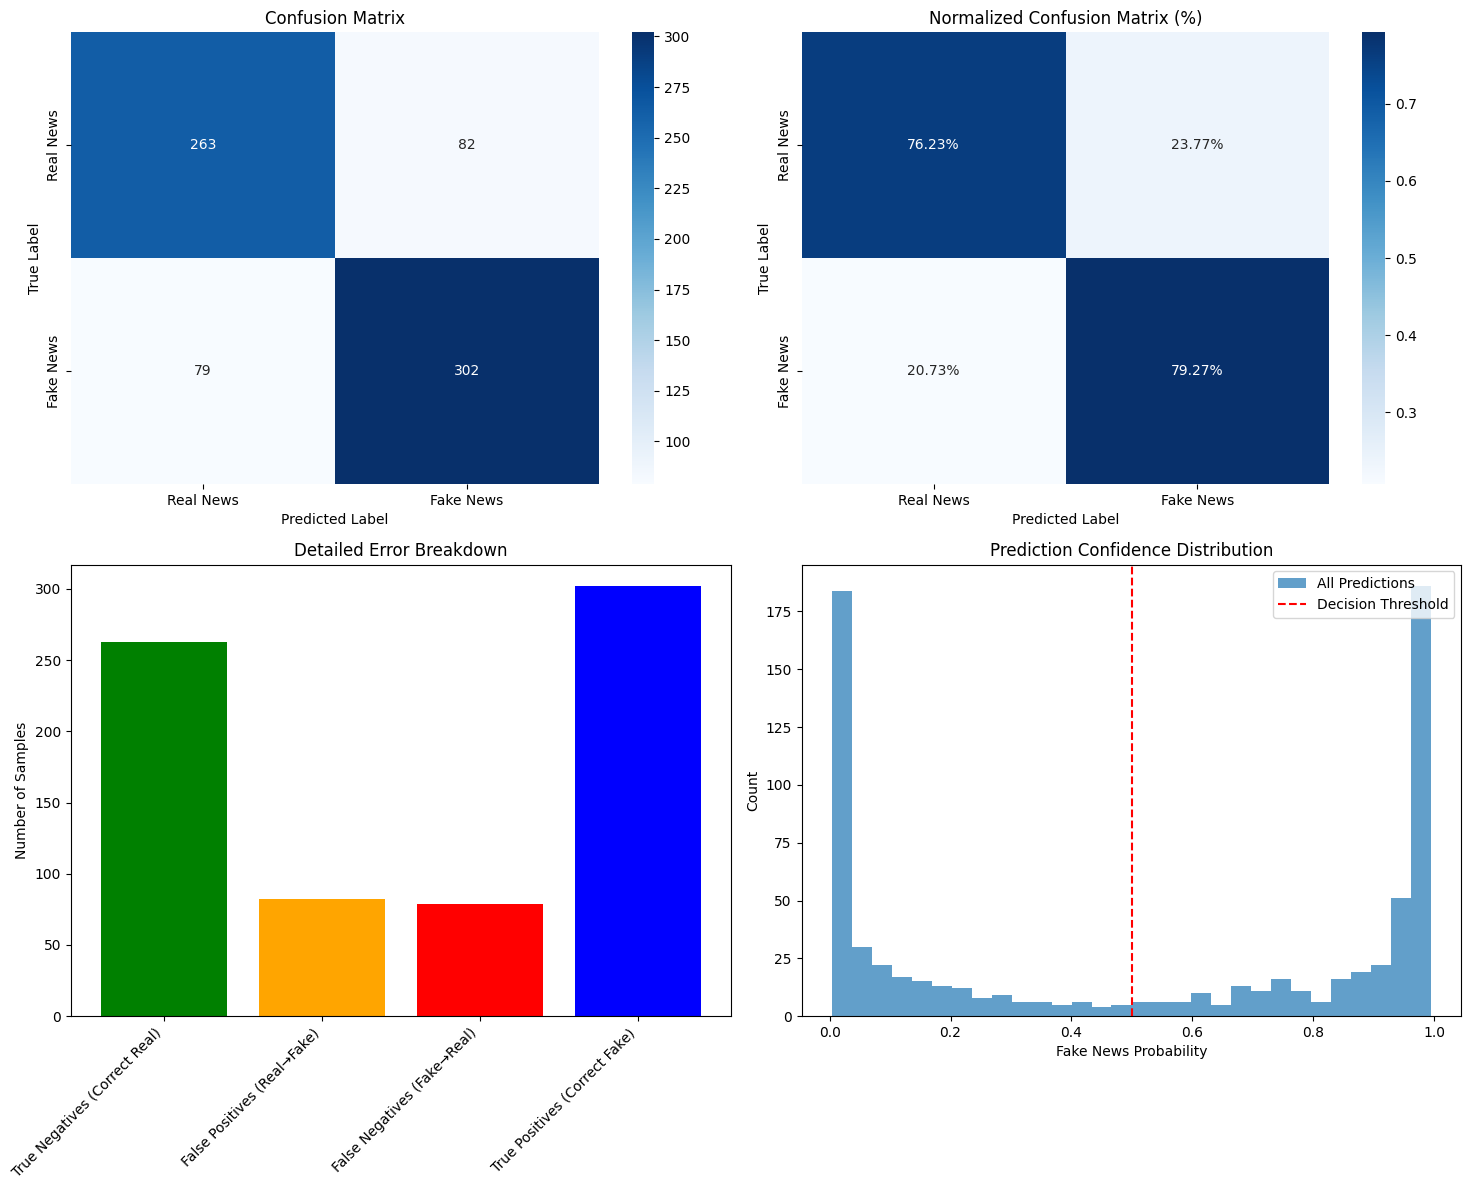

🔍 DETAILED CONFUSION MATRIX ANALYSIS
True Negatives (TN): 263 - Correctly identified Real News
False Positives (FP): 82 - Real News misclassified as Fake
False Negatives (FN): 79 - Fake News misclassified as Real
True Positives (TP): 302 - Correctly identified Fake News

📈 ERROR PATTERN ANALYSIS:
• False Positive Rate among errors: 50.9%
• False Negative Rate among errors: 49.1%
⚠️  Model tends to be more aggressive (flags real news as fake)

🎯 CONFIDENCE ANALYSIS:
• Samples with low confidence (40-60%): 33
• High confidence predictions: 693


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import numpy as np

def detailed_confusion_matrix_analysis(y_true, y_pred, y_pred_proba, class_names=['Real News', 'Fake News']):
    """Comprehensive confusion matrix analysis"""
    
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 1. Basic Confusion Matrix
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,0])
    axes[0,0].set_title('Confusion Matrix')
    axes[0,0].set_xlabel('Predicted Label')
    axes[0,0].set_ylabel('True Label')
    
    # 2. Normalized Confusion Matrix (Percentages)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names, ax=axes[0,1])
    axes[0,1].set_title('Normalized Confusion Matrix (%)')
    axes[0,1].set_xlabel('Predicted Label')
    axes[0,1].set_ylabel('True Label')
    
    # 3. Error Analysis
    tn, fp, fn, tp = cm.ravel()
    
    error_data = {
        'True Negatives (Correct Real)': tn,
        'False Positives (Real→Fake)': fp,
        'False Negatives (Fake→Real)': fn,
        'True Positives (Correct Fake)': tp
    }
    
    colors = ['green', 'orange', 'red', 'blue']
    axes[1,0].bar(error_data.keys(), error_data.values(), color=colors)
    axes[1,0].set_title('Detailed Error Breakdown')
    axes[1,0].set_ylabel('Number of Samples')
    plt.setp(axes[1,0].get_xticklabels(), rotation=45, ha='right')
    
    # 4. Prediction Confidence Distribution
    axes[1,1].hist(y_pred_proba[:, 1], bins=30, alpha=0.7, label='All Predictions')
    axes[1,1].axvline(0.5, color='red', linestyle='--', label='Decision Threshold')
    axes[1,1].set_title('Prediction Confidence Distribution')
    axes[1,1].set_xlabel('Fake News Probability')
    axes[1,1].set_ylabel('Count')
    axes[1,1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Detailed Analysis Report
    print("🔍 DETAILED CONFUSION MATRIX ANALYSIS")
    print("=" * 50)
    print(f"True Negatives (TN): {tn} - Correctly identified Real News")
    print(f"False Positives (FP): {fp} - Real News misclassified as Fake")
    print(f"False Negatives (FN): {fn} - Fake News misclassified as Real")
    print(f"True Positives (TP): {tp} - Correctly identified Fake News")
    print()
    
    # Error Analysis
    print("📈 ERROR PATTERN ANALYSIS:")
    total_errors = fp + fn
    if total_errors > 0:
        fp_rate = fp / total_errors * 100
        fn_rate = fn / total_errors * 100
        print(f"• False Positive Rate among errors: {fp_rate:.1f}%")
        print(f"• False Negative Rate among errors: {fn_rate:.1f}%")
        
        if fp > fn:
            print("⚠️  Model tends to be more aggressive (flags real news as fake)")
        elif fn > fp:
            print("⚠️  Model tends to be more conservative (misses some fake news)")
        else:
            print("✅ Model shows balanced error patterns")
    
    # Confidence Analysis
    low_confidence = np.sum((y_pred_proba[:, 1] > 0.4) & (y_pred_proba[:, 1] < 0.6))
    print(f"\n🎯 CONFIDENCE ANALYSIS:")
    print(f"• Samples with low confidence (40-60%): {low_confidence}")
    print(f"• High confidence predictions: {len(y_pred) - low_confidence}")
    
    return cm, error_data

# Usage with your model
y_pred, y_pred_proba, y_true = get_predictions_and_probabilities(text_model, test_loader, device)
cm_analysis = detailed_confusion_matrix_analysis(y_true, y_pred, y_pred_proba)
